## GLMAT: 2D kernel, song stimuli, ML+MC estimation

This notebook demonstrates the full assimilation technique using song stimuli. The song waveform is processed to a 2D spectrogram, then convolved with a 2D STRF to produce the "voltage" of the GLMAT model. The adaptation "current" is calculated by convolving the spike trains with two exponential kernels. The goal of the assimilation is to estimate the parameters of the RF and the adaptation kernels. The parameter count of the RF is minimized by using a low-rank approximation (i.e., an outer product of two vectors) and by projecting time into a basis set of raised cosine filters that are spaced exponentially.

The approach is to use elastic-net penalized maximum-likelihood estimation to get a first guess at the parameters. This model uses the time-compression basis set but does not factorize the RF. The next step involves factorizing the RF to further reduce the parameters and then using MCMC to sample the posterior distribution of the parameters.

In [1]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np

from dstrf import strf, mle, io, spikes, performance

# plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package

sns.set_style("whitegrid")
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


The MAT model is governed by a small number of parameters: the spike threshold (omega), the amplitudes of the adaptation kernels (alpha_1, alpha_2), the time constants of the adaptation kernels (tau_1, tau_2), and the absolute refactory period. In addition, a function must be chosen for spike generation. The 'softplus' function, log(1 + exp(mu)), is a good choice because it doesn't saturate as readily when mu is large. Because there can only be one spike per bin, saturation causes the estimated parameters to be less than the true parameters.

In [2]:
# model parameters: (ω, α1, α2, τ1, τ2, tref)
ntaus = 2
# matparams = np.asarray([7, 100, 2, 10, 200, 2], dtype='d')
matparams = np.asarray([8, -2, 1, 10, 200, 2], dtype='d')
model_dt = 0.5
nlin = "exp"

matparams_i = [0,1,2]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

In [3]:
# STRF: keep this very simple for proof of principle
stim_dt = 3.0
upsample = int(stim_dt / model_dt)
spec_window = 4.0
spec_compress = 10
f_min = 1.0
f_max = 8.0
nfreq = 20
ntau  = 40
# these parameters influence how the STRF dimensional reduction will work
ntbas = 12       # number of temporal basis functions
krank = 1        # rank of bilinear approximation
kcosbas = strf.cosbasis(ntau, ntbas)
ntbas = kcosbas.shape[1]

Here we load some data from a real neural recording from the CRCNS dataset. We're going to replace the actual neural response with a simulation based on the dstrf model. In the original experiment, stimuli were presented individually in a pseudorandom order. To simplify the model, we concatenate the stimuli, setting padding between the stimuli sufficient to capture any offset responses.

The method of concatenation is a bit clumsy, because we don't know what was "presented" during the silent gaps. Simply filling in zeros is not a good idea, because this creates edges in the spectrogram that were not present in the actual stimulation. The current solution is to use the first and last frames of the spectrograms, but some sort of linear ramping to further eliminate transients would be even better.

In [4]:
# data parameters - the number of trials for assimilation and for testing
pad_before = 0    # how much to pad stimulus before onset
pad_after = ntau * stim_dt # how much to pad after offset
n_trials = 5      # set the number of trials to use (needs to be the same for all stimuli)
p_test = 0.2      # proportion of trials to use for test

# song stimulus:
root = os.path.join(os.environ["HOME"], "data", "crcns")
cell = "blabla0903_2_B"
stim_type = "conspecific"
data = io.load_crcns(cell, stim_type, root, spec_window, stim_dt, f_min=f_min, f_max=f_max, f_count=nfreq, 
                     compress=spec_compress, gammatone=True)
io.pad_stimuli(data, pad_before, pad_after, fill_value=0.0);

This code generates the simulated response. First we convolve the stimulus with the RF and then use the MAT model to generate spikes from a non-homogeneous Poisson process (optionally using a softplus nonlinearity, which makes the model not-quite-Poisson)

RF names: ['bbm', 'wb2', 'nbtf', 'nbs', 'bbf', 'nbts', 'off', 'bbs']


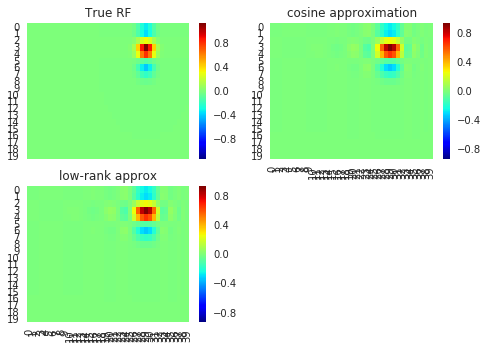

In [5]:
kscale = 2.5

from scipy.signal import resample
filts = np.load('../../filters.npz')
print("RF names: {}".format(filts.keys()))
#k1 = resample(filts['nbs'] * kscale, nfreq, axis=0)[:,ntau-1::-1]
k1 = filts['nbs'][3:nfreq+3,ntau-1::-1] * kscale
k1c = strf.to_basis(k1, kcosbas)
k1f, k1t = strf.factorize(k1c, rank=krank)

plt.subplot(221)
ax = sns.heatmap(np.flipud(k1), cmap='jet', xticklabels=False)
ax.set_title("True RF")
plt.subplot(222)
ax = sns.heatmap(np.flipud(strf.from_basis(k1c, kcosbas)), cmap='jet')
ax.set_title("cosine approximation");
plt.subplot(223)
k1v = np.concatenate([k1f.flatten(), k1t.flatten()])
ax = sns.heatmap(np.flipud(strf.from_basis(strf.defactorize(k1v, nfreq, krank), kcosbas)), cmap='jet')
ax.set_title("low-rank approx")

In [6]:
import mat_neuron._model as mat
mat.random_seed(1)

def predict_spikes(V, params, dt, upsample):
    omega, a1, a2, t1, t2, tref = params
    if nlin == "exp":
        f = mat.predict_poisson
    elif nlin == "softplus":
        f = mat.predict_softplus
    return f(V - omega, (a1, a2), (t1, t2), tref, dt, upsample)

for d in data:
    nchan, nframes = d["stim"].shape
    nbins = nframes * upsample
    spike_v = np.zeros((nbins, n_trials), dtype='i')
    spike_h = np.zeros((nbins, ntaus, n_trials), dtype='d')
    V = strf.convolve(d["stim"], k1)
    spike_t = []
    for i in range(n_trials):
        spike_v[:, i] = predict_spikes(V, matparams, model_dt, upsample)
        spike_h[:, :, i] = mat.adaptation(spike_v[:, i], matparams[3:5], model_dt)
        spike_t.append(spike_v.nonzero()[0])
    d["spike_v"] = spike_v
    d["spike_h"] = spike_h
    d["spike_t"] = spike_t
    d["spike_dt"] = model_dt
    
n_test = int(p_test * len(data))
# split into assimilation and test sets and merge stimuli
assim_data = io.merge_data(data[:-n_test])
test_data = io.merge_data(data[-n_test:])

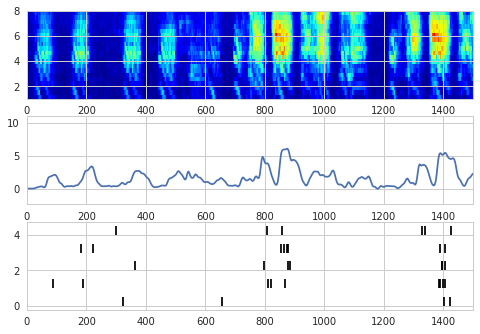

In [7]:
plt.subplot(311).imshow(assim_data["stim"], extent=(0, assim_data["duration"], f_min, f_max))
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])
V = strf.convolve(assim_data["stim"], k1)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for i, spk in enumerate(assim_data["spike_t"]):
    ax.vlines(spk * model_dt, i, i + 0.5)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 1500)

## Estimate parameters

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for the initial ML estimation. Note that we supply the nonlinearity function to the constructor too, as this determines how the log-likelihood is calculated.

In [9]:
# the parameters of the generative model:
theta_true = np.r_[matparams[:3], strf.as_vector(k1c)]
# initial guess of parameters using penalized ML. Note that we provide the cosine basis set to the constructor of
# mle.estimator, which causes the design matrix to be in the cosine basis set
mlest = mle.mat(assim_data["stim"], kcosbas, assim_data["spike_v"], assim_data["spike_h"],
                assim_data["stim_dt"], assim_data["spike_dt"], nlin=nlin)
# also construct an estimator for the test object so we can score results
mltest = mle.mat(test_data["stim"], kcosbas, test_data["spike_v"], test_data["spike_h"],
                       test_data["stim_dt"], test_data["spike_dt"], nlin=nlin)
print("l(theta_true) = {}".format(mlest.loglike(theta_true)))

l(theta_true) = 5599.44765958


In [10]:
# low-rank estimators
mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                assim_data["stim_dt"], assim_data["spike_dt"], nlin=nlin)
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                       test_data["stim_dt"], test_data["spike_dt"], nlin=nlin)

In [11]:
%time w0 = mlest.estimate(reg_lambda=1e1, reg_alpha=1e1)

Optimization terminated successfully.
         Current function value: 3807.299676
         Iterations: 45
         Function evaluations: 60
         Gradient evaluations: 104
         Hessian evaluations: 266
CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


[ 8. -2.  1.]
[ 7.93022597 -0.11465821  0.52599757]


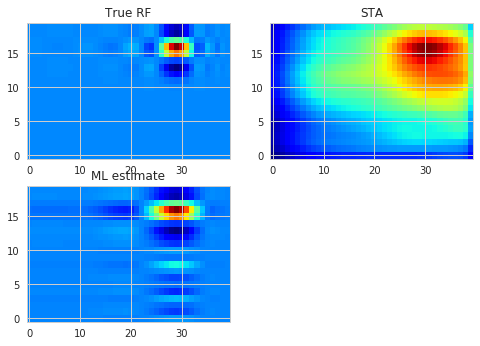

In [12]:
print(matparams[:3])
print(w0[:3])
# the RF is in the cosine basis set, which we need to convert back in order to visualize
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
#rf_mle = strf.as_matrix(w0[3:], kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
plt.subplot(221).imshow(strf.from_basis(k1c, kcosbas))
plt.title("True RF")
plt.subplot(222).imshow(rf_sta)
plt.title("STA")
plt.subplot(223).imshow(rf_mle)
plt.title("ML estimate")

In [13]:
import progressbar
from dstrf import crossvalidate

#reg_grid = np.logspace(-1, 5, 50)[::-1]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]
reg_grid = np.logspace(-1, 5, 20)[::-1]
scores = []
results = []

bar = progressbar.ProgressBar(max_value=len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])
for reg, s, w in bar(crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False)):
    scores.append(s)
    results.append((reg, s, w))
    
best_idx = np.argmax(scores)
best = results[best_idx]
print("best solution at {}: {}".format(best[0], best[1]))
rf_alpha, rf_lambda = best[0]
w0 = best[2]

 [Elapsed Time: 0:13:58] |####################################| (Time: 0:13:58) 


best solution at (7.4552197183388795, 0.39237998517573086): -3811.9518715


[ 8. -2.  1.]
[ 7.92955552 -0.09230078  0.53570556]


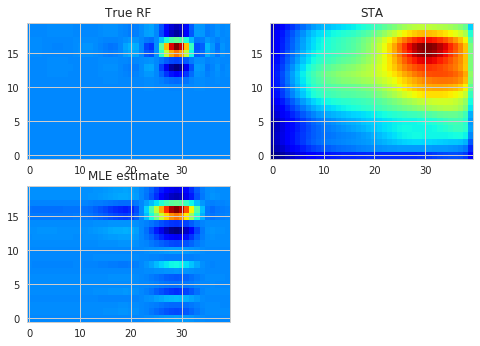

In [14]:
print(matparams[:3])
print(w0[:3])
# the RF is in the cosine basis set, which we need to convert back in order to visualize
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
# rf_mle = strf.as_matrix(w0[3:], kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], nfreq, krank), kcosbas)
plt.subplot(221).imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
plt.title("True RF")
plt.subplot(222).imshow(rf_sta, cmap='jet', aspect='auto')
plt.title("STA")
plt.subplot(223).imshow(rf_mle, cmap='jet', aspect='auto')
plt.title("MLE estimate")

loglike: -980.810261095
CC: 0.174841390196/0.221288883806
spike count: data = 180, pred = 152


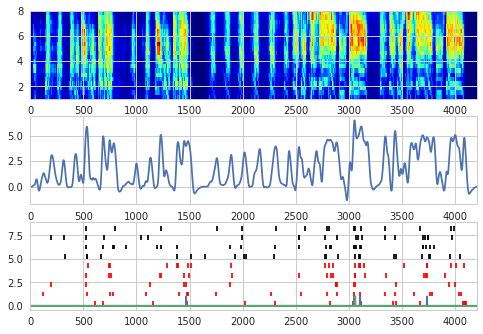

In [15]:
mat.random_seed(1)
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))
V = mltest.V(w0)
plt.subplot(312).plot(t_stim, V)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * model_dt, j, j + 0.5, 'r')
pred = np.zeros_like(test_data["spike_v"])
for i in range(j):
    pred[:, i] = mltest.predict(w0, matparams[3:], V)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * model_dt, i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("loglike: {}".format(-mltest.loglike(w0)))
print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))

We'll use the ML estimate to seed the MCMC sampler. We're going to reduce the size of the parameter space by factorizing the RF (i.e., a bilinear approximation). Note that we try to use the mlest object as much as possible to do the calculations rather than reimplement things; however, there can be some significant performance enhancements from an optimized implementation.

In [39]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos

# the MAT parameters are just bounded between reasonable limits. These may need to be expanded when using real data.
mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

rf_alpha, rf_lambda = best[0]

def lnpost(theta):
    """Posterior probability for dynamical parameters"""
    mparams = theta[:3]
    rfparams = theta[3:]
    #rf_prior = -np.sum(np.abs(rfparams)) * rf_alpha - np.dot(rfparams, rfparams) * rf_lambda
    ll = mat_prior(mparams) #+ rf_prior
    if not np.isfinite(ll):
        return -np.inf
    w = np.r_[mparams, rfparams]
    ll -= mlest.loglike(w, rf_lambda, rf_alpha)
    return -np.inf if not np.isfinite(ll) else ll

In [40]:
# get low-rank approx of the ML STRF
# k0f, k0t = strf.factorize(strf.as_matrix(w0[3:], ntbas))
# rf_mlb = strf.from_basis(np.dot(k0f, k0t), kcosbas)
# w0_bl = np.r_[w0[:3], k0f.squeeze(), k0t.squeeze()]
print("lnpost of ML estimate: {}".format(lnpost(w0)))
%timeit lnpost(w0)

lnpost of ML estimate: -1050.45463975
100 loops, best of 3: 3.06 ms per loop


This code starts the MCMC sampler. We initialize the walkers (chains) in a gaussian around the ML estimate, with standard deviation 2x the absolute value of the best guess. The model converges fairly quickly, but then we let it sample for a while.

In [49]:
import emcee
# assimilation parameters
if sys.platform == 'darwin':
    nthreads = 1
else:
    nthreads = 8
nwalkers = 1500
nsteps = 1000

# initialize walkers
pos = p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 2)
# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, w0.size, lnpost, threads=nthreads)

In [50]:
# start the sampler
tracker = utils.convergence_tracker(nsteps, 100)
for pos, prob, like in tracker(sampler.sample(pos, iterations=nsteps, storechain=True)): 
    continue

  step  μ(lnprob)  Δ(lnprob)  σ(lnprob)        time         ETA
------------------------------------------------------------------
   100    -3001.4        inf      72585     0:01:13     0:11:07
   200    -1107.2     1894.3     197.78     0:02:26     0:09:49
   300      -1094     13.206     139.03     0:03:39     0:08:35
   400    -1087.3     6.7053     115.63     0:04:52     0:07:21
   500    -1081.2     6.0618     94.151     0:06:05     0:06:07
   600    -1076.5     4.6591     76.792     0:07:19     0:04:53
   700      -1073     3.4976     65.258     0:08:32     0:03:40
   800    -1070.1     2.9239     52.299     0:09:45     0:02:27
   900    -1067.4     2.6779     41.474     0:10:58     0:01:13
  1000    -1065.7     1.7573     36.246     0:12:11     0:00:00
  1001    -1065.6   0.080854      36.03     0:12:12     0:00:00


lnpost of p median: -1057.16629831
average acceptance fraction: 0.185807333333
[ 7.92955552 -0.09230078  0.53570556]
[ 8.14802988 -0.01313123  0.43217465]
mle error: 0.510941907581; map error: 0.60303441144


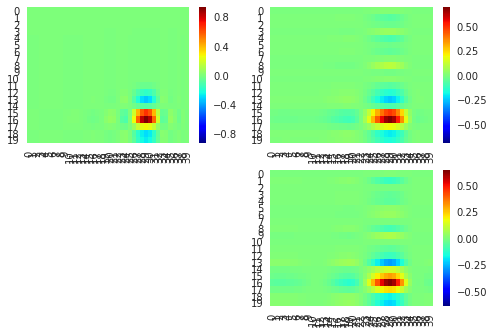

In [51]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
try:
    print("autocorrelation time: {}".format(sampler.acor))
except:
    pass    
w1 = np.median(pos, 0)
rfparams = w1[3:]
kf = rfparams[:nfreq]
kt = rfparams[nfreq:]
rf_map = strf.from_basis(np.outer(kf, kt), kcosbas)
print(w0[:matparams_n])
print(w1[:matparams_n])
print("mle error: {}; map error: {}".format(strf.subspace(k1, rf_mle), strf.subspace(k1, rf_map)))
plt.subplot(221)
sns.heatmap(strf.from_basis(k1c, kcosbas), cmap='jet')
plt.subplot(222)
sns.heatmap(rf_mle, cmap='jet')
plt.subplot(224)
sns.heatmap(rf_map, cmap='jet')

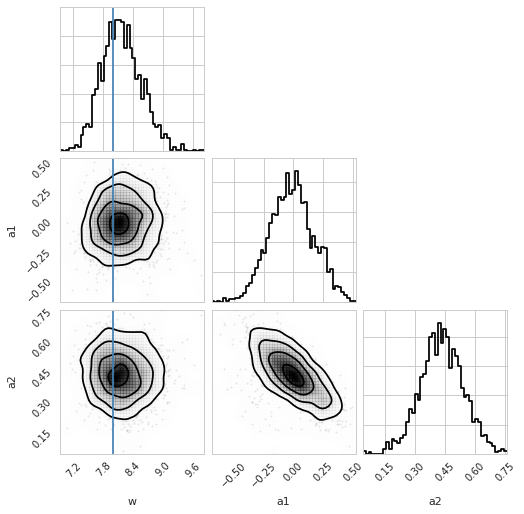

In [52]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['w','a1','a2',]
c = corner(mpos,
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams[:3])

loglike: -980.810261095
CC: 0.475761469065/0.221288883806
spike count: data = 36.0, pred = 40.9


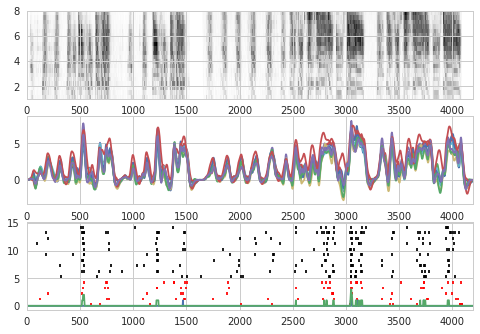

In [62]:
mat.random_seed(1)
n_draw = 10
t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
plt.subplot(311).imshow(test_data["stim"], extent=(0, test_data["duration"], f_min, f_max))
vax = plt.subplot(312)
ax = plt.subplot(313)
for j, spk in enumerate(test_data["spike_t"]):
    ax.vlines(spk * model_dt, j, j + 0.5, 'r')
    
samples = np.random.permutation(nwalkers)[:n_draw]
pred = np.zeros((test_data["spike_v"].shape[0], n_draw), dtype=test_data["spike_v"].dtype)
for i, idx in enumerate(samples):
    mparams = pos[idx]
    V_mc = mltest.V(mparams)
    vax.plot(t_stim, V_mc)
    pred[:, i] = mltest.predict(mparams, matparams[3:], V_mc)
    spk_t = pred[:, i].nonzero()[0]
    ax.vlines(spk_t * model_dt, i + j + 1, i + j + 1.5)
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
ax.plot(t_stim, test_psth, t_stim, pred_psth)
for ax in plt.gcf().axes:
    ax.set_xlim(0, 4200)

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("loglike: {}".format(-mltest.loglike(w0)))
print("CC: {}/{}".format(np.corrcoef(test_psth, pred_psth)[0, 1], eo))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum() / n_trials, pred.sum() / n_draw))

In [ ]:
# posterior predictive distribution
stim = test_data["stim"]
V = strf.convolve(stim, k1)
for j in range(n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample)
    z = np.nonzero(spikes)[0]
    plt.vlines(z, j, j + 0.5, 'r')

mparams = matparams.copy()
samples = np.random.permutation(nwalkers)[:n_test]
for i, idx in enumerate(samples):
    rfparams = pos[idx, matparams_n:]
    k = strf.defactorize(rfparams, nfreq, krank)
    rf = strf.from_basis(k, kcosbas)
    V = strf.convolve(stim, rf)
    mparams[matparams_i] = pos[idx, :matparams_n]
    S = predict_spikes(V, mparams, model_dt, upsample)
    spk_t = S.nonzero()[0]
    plt.vlines(spk_t, i + j + 1, i + j + 1.5)

plt.xlim(0, 1000)

In [ ]:
# save data for testing in the Pillow code
import scipy.io as sio
V = mlest.V_interp(theta_true).squeeze()
H = assim_resp[0]["H"]
mu = V - H[:, 0] * matparams[1] - H[:, 1] * matparams[2] - matparams[0]
sio.savemat('glmat_2dbi_song_twin.mat', {"stim": (stim - stim.mean(1)[:, np.newaxis]) / stim.std(1)[:, np.newaxis], 
                                         "spikes": assim_resp[0]["spike_v"],
                                         "stim_dt": stim_dt,
                                         "spike_dt": model_dt,
                                         "rf": k1,
                                         "Istim": V,
                                         "Itot": mu})